In [1]:
plt.style.use('bmh')
# plt.style.use('ggplot')
# plt.style.use('seaborn')
# plt.style.use('default')
# plt.style.use('fivethirtyeight')

### Floor description

#### 1. Read datasets

In [2]:
# Read clean dataset
feats = [
    'Property_UPRN',
    'Current energy efficiency rating',
    'Total current energy costs over 3 years (£)',
    'CO2 Emissions Current Per Floor Area (kg.CO2/m²/yr)'
]
df0 = pd.read_csv('data/data_clean.csv')[feats]
# create rating
df0['CO2_rating'] = pd.qcut(df0[feats[-1]], q = 5, labels = range(1,6)).astype(int)
df0['CO2_rating'] = 6 - df0.CO2_rating
display(df0.CO2_rating.value_counts().sort_index())

1    36938
2    34265
3    37728
4    37016
5    39092
Name: CO2_rating, dtype: int64

In [3]:
# read preprocessed dataset
df1 = pd.read_csv('data/descriptions/FLOOR_DESCRIPTION.csv', sep = '|')
df1 = df1.merge(df0, on = 'Property_UPRN', how = 'left')

#### 2. Data cleaning

In [4]:
l = 'Average thermal transmittance '
df1['ATT'] = df1.FLOOR_DESCRIPTION.map(lambda x: float(x[len(l):].split(' ')[0]) if x.startswith(l) else np.nan)

In [5]:
# df1.ATT.value_counts()

In [6]:
# df1.describe(include = 'all')

In [7]:
df1['FLOOR_TYPE'] = df1.FLOOR_DESCRIPTION.map(lambda x: x.split(',')[0].strip() if not x.startswith(l) else np.nan)
df1['FLOOR_INS']  = df1.FLOOR_DESCRIPTION.map(lambda x: x.split(',')[-1].strip() if not x.startswith(l) else np.nan)

In [8]:
df1.FLOOR_TYPE.value_counts().to_dict()

{'Suspended': 88702,
 'Solid': 33686,
 'To unheated space': 3983,
 'To external air': 1027}

In [9]:
df1.FLOOR_INS.value_counts().to_dict()

{'no insulation (assumed)': 89434,
 'insulated (assumed)': 26239,
 'limited insulation (assumed)': 8245,
 'insulated': 3480}

In [10]:
# replacing
dict_repl = {
 'no insulation (assumed)': 'no',
 'insulated (assumed)': 'yes',
 'limited insulation (assumed)': 'partial',
 'insulated': 'yes'
}
df1['FLOOR_INS'] = df1.FLOOR_INS.map(dict_repl)

In [11]:
df1.FLOOR_INS.value_counts()

no         89434
yes        29719
partial     8245
Name: FLOOR_INS, dtype: int64

#### 3. Ratings vizualisation

In [12]:
feats_gr = ['FLOOR_TYPE', 'FLOOR_INS']
feats_ag = ['CO2_rating']
colors_list = ['red','orange','green']

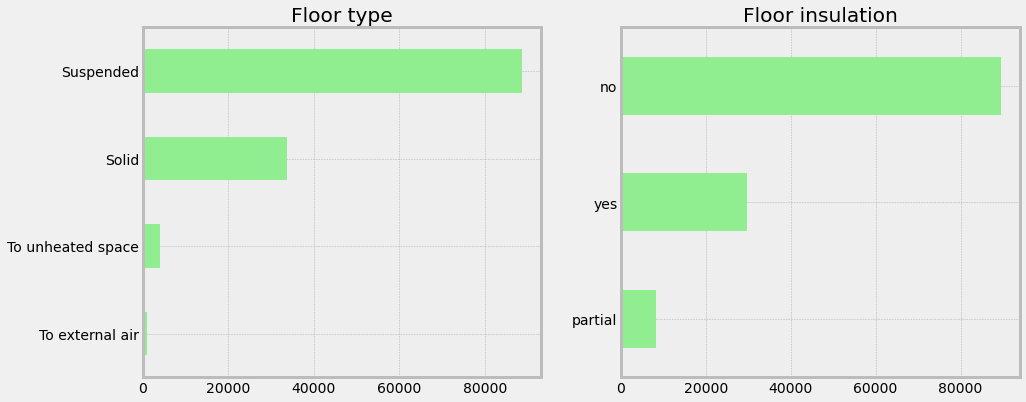

In [13]:
# popularity by wall types and insulation
_, ax = plt.subplots(1,2, figsize = (14,6))
_ = df1.groupby(feats_gr[0]).size().sort_values().plot(kind = 'barh', ax = ax[0], ylabel = '', color = 'lightgreen', title = 'Floor type')
_ = df1.groupby(feats_gr[1]).size().sort_values().plot(kind = 'barh', ax = ax[1], ylabel = '', color = 'lightgreen', title = 'Floor insulation')

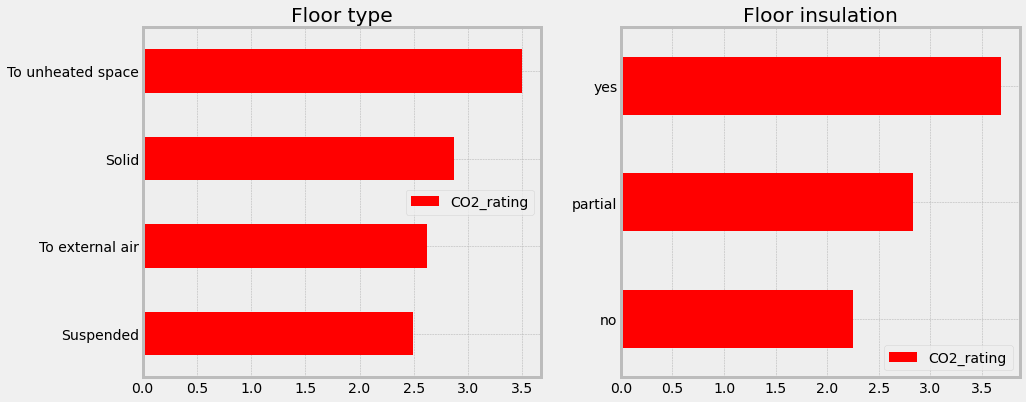

In [14]:
# ratings by wall types and insulation
_, ax = plt.subplots(1,2, figsize = (14,6))
_ = df1.groupby(feats_gr[0])[feats_ag].mean().sort_values('CO2_rating').plot(kind = 'barh', ax = ax[0], ylabel = '', color = colors_list, title = 'Floor type')
_ = df1.groupby(feats_gr[1])[feats_ag].mean().sort_values('CO2_rating').plot(kind = 'barh', ax = ax[1], ylabel = '', color = colors_list, title = 'Floor insulation')

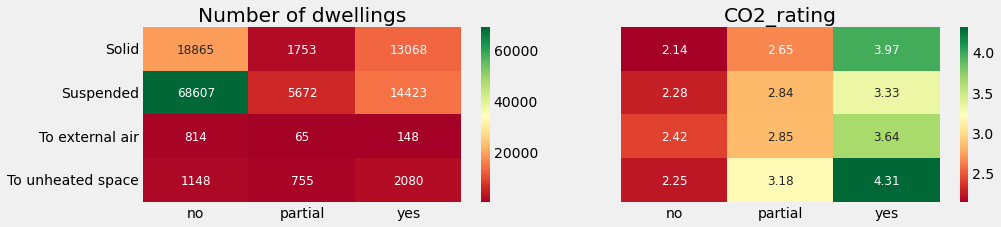

In [15]:
# heatmaps
_, ax = plt.subplots(1,2, figsize = (14,3))

df_corr = df1.groupby(feats_gr).size().unstack()
p = sns.heatmap(df_corr, ax = ax[0], cmap = 'RdYlGn', annot = True, fmt = '.0f', annot_kws={"size": 12})
_ = p.set_xlabel('')
_ = p.set_ylabel('')
_ = p.set_title('Number of dwellings')

k = 0
df_corr = df1.groupby(feats_gr)[feats_ag[k]].mean().unstack()
p = sns.heatmap(df_corr, ax = ax[1], cmap = 'RdYlGn', annot = True, fmt = '.2f', annot_kws={"size": 12})
_ = p.set_xlabel('')
_ = p.set_yticklabels('')
_ = p.set_ylabel('')
_ = p.set_title(feats_ag[k])


#### 4. Correlations algorithm

In [16]:
# 1) create splittings
feats_gr = [
    'FLOOR_TYPE', 
    'FLOOR_INS',
]
feats_ag = [
    'Current energy efficiency rating',
    'Total current energy costs over 3 years (£)',
    'CO2 Emissions Current Per Floor Area (kg.CO2/m²/yr)'
]
           
df2 = df1.groupby(feats_gr)[feats_ag[-1]].agg([len,np.mean]).reset_index()
df2['group_name'] = df2[feats_gr].apply(lambda x: '_'.join([str(x1) for x1 in x]), axis = 1)
df2.loc[df2['len'] < 100, 'group_name'] = '_OTHER'
del df2['len']
del df2['mean']
print(df2.shape)

# merge with initial dataset
df1 = df1.merge(df2, how = 'left', on = feats_gr)

(12, 3)


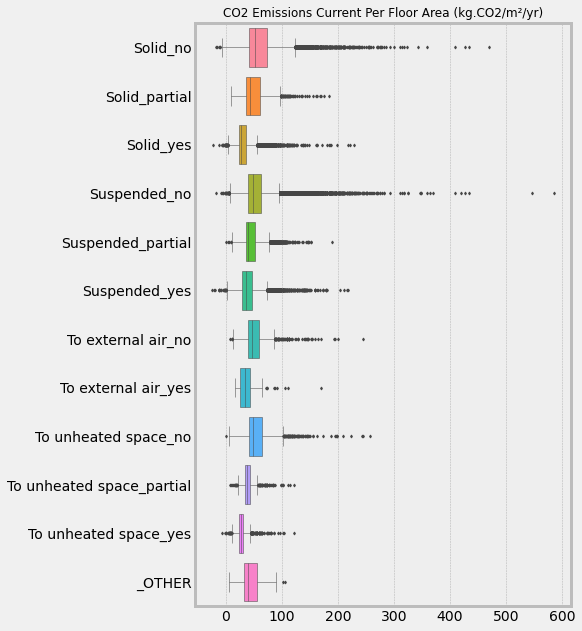

In [17]:
# 2) Plot boxplot to visually compare distributions
list_groups = sorted(df1[~df1.group_name.isnull()].group_name.unique())
feat = feats_ag[-1]
_, ax = plt.subplots(1,1, figsize = (6,10))
p = sns.boxplot(y=df1.group_name, x=df1[feat], ax = ax, order = list_groups, linewidth=0.5, saturation=1, fliersize = 2)
_ = p.set_title(feat, fontsize = 12)
_ = p.set_ylabel('')
_ = p.set_xlabel('')

In [18]:
# 3) Conduct ANOVA statistical test to have numerical value of similarity between these variables.
from scipy import stats
data = df1.groupby('group_name')[feat].agg(lambda x: list(x))
fvalue, pvalue = stats.f_oneway(*data)
fvalue, pvalue

(1772.2645269904644, 0.0)

#### 5. Feature engineering
- Calculate average values of features Current energy efficiency rating and Total current energy costs over 3 years (£) by the groups that described above.
- Calculate average of feature rating (if exists, or CO2 rating otherwise).
- Create new features on the Property_UPRN level and replace the categorical features by that 3 new numerical features.
- We will use that features in the modelling and recommendation parts.

In [19]:
# Calculate average values of features Current energy efficiency rating and Total current energy costs over 3 years (£) by the groups.
pre = 'Floor_'
df2 = df1.groupby(feats_gr)[feats_ag[:-1]].agg([len, np.mean])
df2.columns = [pre+'eff_len',pre+'eff_mean',pre+'cost_len',pre+'cost_mean']
df2.reset_index(inplace = True)
df2['group_name'] = df2[feats_gr].apply(lambda x: '_'.join([str(x1) for x1 in x]), axis = 1)
df2.loc[df2[pre+'eff_len'] < 100, 'group_name'] = '_OTHER'
del df2[pre+'eff_len']
del df2[pre+'cost_len']

In [20]:
# Create new features on the Property_UPRN level and replace the categorical features by that new numericals
df2 = df2.groupby('group_name')[pre+'eff_mean',pre+'cost_mean'].mean().reset_index()
df1 = df1.merge(df2)
df3 = df1.groupby('Property_UPRN')[pre+'eff_mean',pre+'cost_mean'].mean().reset_index()

In [21]:
# Add average feature rating
df4 = df1.groupby('Property_UPRN')['CO2_rating'].mean().reset_index().rename(columns = {'CO2_rating':pre+'rating'})
df3 = df3.merge(df4)
print(df3.shape)
df3[:3]

(111404, 4)


,Property_UPRN,Floor_eff_mean,Floor_cost_mean,Floor_rating
0,1000001648,62.74,"3,356.01",3.00
1,1000001652,62.74,"3,356.01",2.00
2,1000001688,62.74,"3,356.01",3.00


In [22]:
# We will use that features in the modelling part.
df3.to_csv('data/features/FLOOR_DESCRIPTION.csv', index = False, encoding = 'utf8', sep = '|')